In [1]:
import numpy as np
import sys
from pathlib import Path

sys.path.append('../code/')

from mlalgos import BuildNN
from mllib import Utilities,MLUtilities

from time import time
import pickle

import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib as mpl
import matplotlib.colors as pltcol
import gc

ut = Utilities()
ml = MLUtilities()

In [2]:
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['xtick.top'] = True
mpl.rcParams['ytick.right'] = True
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['legend.fontsize'] = 14 # 14
mpl.rcParams['legend.labelspacing'] = 0.25
FS = 18
FS2 = 15
FS3 = 13
FSL = 22

mpl.rcParams['xtick.major.size'] = 6
mpl.rcParams['xtick.minor.size'] = 3
mpl.rcParams['ytick.major.size'] = 6
mpl.rcParams['ytick.minor.size'] = 3

#mpl.rcParams.keys()

# Example usage of `BuildNN` 
### for systematically searching over network architectures and hyperparameters

In [3]:
Plot_Stem = 'buildnn/plots'
Path(Plot_Stem).mkdir(parents=True,exist_ok=True)

Save_Fig = True

## Regression example: 1-d Gaussian family
### Function definition

In [4]:
def func_gauss1d(x,params):
    """ Expect x as 1-d array, params as array of shape (0,), (1,) or (2,). """
    mu = params[0] if len(params) > 0 else 0.0
    sig2 = 10**params[1] if len(params) > 1 else 1.0
    return np.exp(-0.5*(x-mu)**2/sig2)/np.sqrt(2*np.pi*sig2)

In [5]:
Shallow = False # True: shallow+wide arch; False: deep+narrow arch
Depth_Str = 'shallow' if Shallow else 'deep'

### Training & testing samples

In [6]:
start_time = time()

print('Generating data for 1-d Gaussian family...')

xmin,xmax = -2.5,3.0

seed = 1983
rng = np.random.RandomState(seed)

n_x_train = 80 if Shallow else 120
xtrain = np.linspace(xmin,xmax,n_x_train)

param_mins = [-0.5,-0.1] if Shallow else [-1,-0.3] # minimum mu,lgsig2
param_maxs = [ 0.5, 0.1] if Shallow else [ 1, 0.3] # maximum mu,lgsig2

#################################################
# Training set
print('... training sample')
n_lhc_train = 30 if Shallow else 45 # no. of Latin hypercube samples
n_params = len(param_mins)

# LHC of shape (n_lhc_train,n_params)
if len(param_mins) > 0:
    params_train = ut.gen_latin_hypercube(Nsamp=n_lhc_train,dim=n_params,param_mins=param_mins,param_maxs=param_maxs,rng=rng) 
else:
    params_train = [[]]

n_train = n_lhc_train*n_x_train

X_train = np.zeros((n_train,n_params+1)) # features = {params},x; X will be transposed later
Y_train = np.zeros((1,n_train))

for n in range(n_lhc_train):
    sl = np.s_[n*n_x_train:(n+1)*n_x_train]
    for p in range(n_params):
        X_train[sl,p] = params_train[n,p]
    X_train[sl,-1] = xtrain
    Y_train[0,sl] = func_gauss1d(xtrain,params_train[n])

X_train = X_train.T
print('... sample of size {0:d} created'.format(n_train))
#################################################
# Testing set
print('... testing sample')
n_x_test = 80 if Shallow else 240
xtest = (xmax-xmin)*rng.random_sample(n_x_test) + xmin

n_lhc_test = 60 if Shallow else 90 # no. of Latin hypercube samples

# LHC of shape (n_lhc_train,n_params)
if len(param_mins) > 0:
    params_test = ut.gen_latin_hypercube(Nsamp=n_lhc_test,dim=n_params,param_mins=param_mins,param_maxs=param_maxs,rng=rng) 
else:
    params_test = [[]]

n_test = n_lhc_test*n_x_test

X_test = np.zeros((n_test,n_params+1)) # features = {params},x; X will be transposed later
Y_test = np.zeros((1,n_test))

for n in range(n_lhc_test):
    sl = np.s_[n*n_x_test:(n+1)*n_x_test]
    for p in range(n_params):
        X_test[sl,p] = params_test[n,p]
    X_test[sl,-1] = xtest
    Y_test[0,sl] = func_gauss1d(xtest,params_test[n])

X_test = X_test.T
print('... sample of size {0:d} created'.format(n_test))
print('... done')
ut.time_this(start_time)

Generating data for 1-d Gaussian family...
... training sample
... sample of size 5400 created
... testing sample
... sample of size 21600 created
... done
0 min 0.00 seconds



### Network setup and training

#### Non-ensembled

File_Stem: buildnn/gf1d_deep
Feed-forward neural network setup...
... found data set of dimension 3 with targets of dimension 1
... found 5400 samples
... fraction 0.800 (4320 samples) will be used for training
... will use residual percentiles for hyperparameter comparison
... setup complete
Initiating search... 
... cycling over 5 repetitions of 48 possible options
... setting tasks
... training using 8 process(es)
[....................] 100% done
[................... ] 96% done
... identifying and saving best network and its teststat and training params
Best test stat = 2.351e-02
Setup params:  {'data_dim': 3, 'loss_type': 'square', 'adam': True, 'seed': None, 'standardize': True, 'file_stem': 'buildnn/gf1d_deep/net', 'verbose': False, 'logfile': None, 'neg_labels': True, 'L': 8, 'wt_decay': 0.0, 'n_layer': [9, 9, 9, 9, 9, 9, 9, 1], 'reg_fun': 'none', 'atypes': ['tanh', 'tanh', 'tanh', 'tanh', 'tanh', 'tanh', 'tanh', 'lin'], 'threshold': None, 'Y_std': array([[0.14541468]]), 'Y_mean

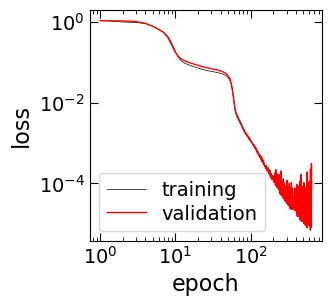

11 min 46.64 seconds



In [7]:
Build = True

Example_Stem = 'gf1d_'+Depth_Str

File_Stem = 'buildnn/' + Example_Stem
print('File_Stem:',File_Stem)

Train_Frac = 0.8                               # fraction of input samples to use for training+validation. 
                                               # remaining used for arch and hyperparam comparisons.
Val_Frac = 0.2                                 # fraction of Train_Frac to use for validation, i.e. early stopping criterion.
Arch_Type = 'emulator:'+Depth_Str              # None or one of ['emulator:deep','emulator:shallow','no_reg','autoenc']. 
Min_Layer = 2                                  # minimum number of layers
Max_Layer = 4                                  # maximum number of layers
Max_Ex = [7,17] if Shallow else [4,6]          # int or list of ints. number of nodes in excess of input dimension 
                                               # (currently forced to be constant across layers)
HTypes = ['tanh','relu']                       # None or subset of ['tanh','relu','lrelu'] 
LRates = [1e-3,3e-3]                           # None or list of floats: learning rates
Wt_Decays = [0.0,0.1]                          # non-empty list of floats: weight decay values
N_Iter = 5                                     # number of iterations for each choice of arch and hyperparams
Loss_Type = 'square'                           # one of ['square','hinge','nll','nllm']
Seed = None                                    # None or int, random number seed.
Check_After = 300 if Shallow else 1000         # epoch after which to activate validation (early stopping) checks
Test_Type = 'perc'                             # one of 'perc' (residual percentiles) or 'mse' (mean squared error). 
                                               # relevant for regression (square/hinge loss).
Parallel = True                                # train networks in parallel
NProc = 8                                      # number of concurrent processes (only relevant if Parallel = True)

start_time = time()
bnn = BuildNN(X_train,Y_train,train_frac=Train_Frac,arch_type=Arch_Type,max_ex=Max_Ex,min_layer=Min_Layer,max_layer=Max_Layer,
              val_frac=Val_Frac,n_iter=N_Iter,wt_decays=Wt_Decays,lrates=LRates,htypes=HTypes,
              parallel=Parallel,nproc=NProc,loss_type=Loss_Type,test_type=Test_Type,seed=Seed,file_stem=File_Stem,ensemble=False)
if Build:
    net,params_train,bts = bnn.trainNN()
    print('Best test stat = {0:.3e}'.format(bts))
    print('Setup params: ',net.params)
    print('Training params: ',params_train)
else:
    net = bnn.load()
    print('Loaded network with')
    print('...    setup params: ',net.params)
    params_train,bts = bnn.load_train()
    print('... best test stat: {0:.3e}'.format(bts))
    print('... training params: ',params_train)

print('No. of free params optimized = {0:d}\n'.format(net.calc_N_freeparams()))

plt.figure(figsize=(3,3))
plt.yscale('log')
plt.xscale('log')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(net.epochs,net.training_loss,'k-',lw=0.5,label='training')
plt.plot(net.epochs,net.val_loss,'r-',lw=1,label='validation')
plt.legend()
plt.show()

residual = np.squeeze(net.predict(X_test)/(Y_test + 1e-15) - 1)

ut.time_this(start_time)

#### Ensembled

File_Stem: buildnn/gf1d_deep_ens
Feed-forward neural network setup...
... found data set of dimension 3 with targets of dimension 1
... found 5400 samples
... fraction 0.800 (4320 samples) will be used for training
... will use residual percentiles for hyperparameter comparison
... setup complete
Initiating search... 
... cycling over 5 repetitions of 72 possible options
... setting tasks
... training using 8 process(es)
[....................] 100% done
... storing best 18 of 360 networks in ensemble
... defining and loading NetworkEnsembleObject
NetworkEnsembleObject initialized
... ... initializing dict self.ensemble
... ... updating ensemble
... ... checking ensemble consistency
... ... defining ensemble weights
... ensemble loaded and checked
Best test stats:
... buildnn/gf1d_deep_ens/ensemble/net_r0: 1.997e-02
{'data_dim': 3, 'loss_type': 'square', 'adam': True, 'seed': None, 'standardize': True, 'file_stem': 'buildnn/gf1d_deep_ens/ensemble/net_r0', 'verbose': False, 'logfile': No

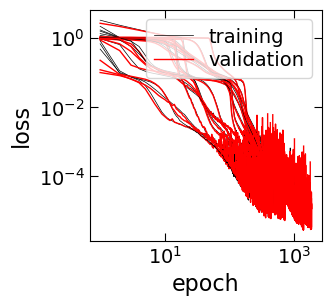

156 min 46.64 seconds



In [8]:
Build = True

Example_Stem = 'gf1d_'+Depth_Str+'_ens'

File_Stem = 'buildnn/' + Example_Stem
print('File_Stem:',File_Stem)

Train_Frac = 0.8                               # fraction of input samples to use for training+validation. 
                                               # remaining used for arch and hyperparam comparisons.
Val_Frac = 0.2                                 # fraction of Train_Frac to use for validation, i.e. early stopping criterion.
Arch_Type = 'emulator:'+Depth_Str              # None or one of ['emulator:deep','emulator:shallow','no_reg','autoenc']. 
Min_Layer = 2                                  # minimum number of layers
Max_Layer = 4                                  # maximum number of layers
Max_Ex = [7,17] if Shallow else [4,6]          # int or list of ints. number of nodes in excess of input dimension 
                                               # (currently forced to be constant across layers)
HTypes = ['tanh','relu']                       # None or subset of ['tanh','relu','lrelu'] 
LRates = [3e-4,1e-3,3e-3]                      # None or list of floats: learning rates
Wt_Decays = [0.0,0.1]                          # non-empty list of floats: weight decay values
N_Iter = 5                                     # number of iterations for each choice of arch and hyperparams
Loss_Type = 'square'                           # one of ['square','hinge','nll','nllm']
Seed = None                                    # None or int, random number seed.
Check_After = 300 if Shallow else 1000         # epoch after which to activate validation (early stopping) checks
Test_Type = 'perc'                             # one of 'perc' (residual percentiles) or 'mse' (mean squared error). 
                                               # relevant for regression (square/hinge loss).
Parallel = True                                # train networks in parallel
NProc = 8                                      # number of concurrent processes (only relevant if Parallel = True)

start_time = time()
bnn = BuildNN(X_train,Y_train,train_frac=Train_Frac,arch_type=Arch_Type,max_ex=Max_Ex,min_layer=Min_Layer,max_layer=Max_Layer,
              val_frac=Val_Frac,n_iter=N_Iter,wt_decays=Wt_Decays,lrates=LRates,htypes=HTypes,
              parallel=Parallel,nproc=NProc,loss_type=Loss_Type,test_type=Test_Type,seed=Seed,file_stem=File_Stem,ensemble=True)
if Build:
    neo = bnn.trainNN()
else:
    neo = bnn.load() # network ensemble object
    print('Loaded ensembled network')

print('Best test stats:')
for n in range(len(neo.keys)):
    key = neo.keys[n]
    print('... '+key+': {0:.3e}'.format(neo.ensemble[key]['teststat']))
    print(neo.ensemble[key]['net'].params)
    print(neo.ensemble[key]['ptrain'])

print('No. of free params optimized:')
for n in range(len(neo.keys)):
    key = neo.keys[n]
    net = neo.ensemble[key]['net']
    print('... '+key+': {0:d}'.format(net.calc_N_freeparams()))

plt.figure(figsize=(3,3))
plt.yscale('log')
plt.xscale('log')
plt.xlabel('epoch')
plt.ylabel('loss')
for n in range(len(neo.keys)):
    key = neo.keys[n]
    net = neo.ensemble[key]['net']
    plt.plot(net.epochs,net.training_loss,'k-',lw=0.5,label='training' if n==0 else None)
    plt.plot(net.epochs,net.val_loss,'r-',lw=1,label='validation' if n==0 else None)
plt.legend()
plt.show()

residual_ens = np.squeeze(neo.predict(X_test)/(Y_test + 1e-15) - 1)

ut.time_this(start_time)

Writing to file: buildnn/plots/gf1d_deep.png
median +- 1sigma
...   single: 0.0217 + 0.2604 - 0.3166 %
... ensemble: -0.0047 + 0.1218 - 0.1126 %


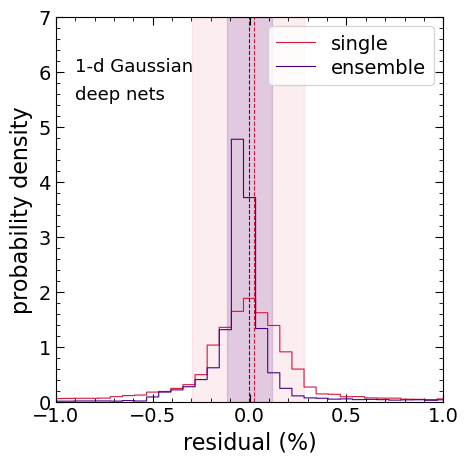

In [9]:
res_16pc = np.percentile(residual,16)*100
res_med  = np.median(residual)*100
res_84pc = np.percentile(residual,84)*100

res_ens_16pc = np.percentile(residual_ens,16)*100
res_ens_med  = np.median(residual_ens)*100
res_ens_84pc = np.percentile(residual_ens,84)*100

bins = np.linspace(-25,25,801)
bin_mid = 0.5*(bins[1:]+bins[:-1])
hist,bins = np.histogram(residual*100,bins=bins,density=False)
hist = hist/residual.size/(bins[1]-bins[0])
hist_ens,bins = np.histogram(residual_ens*100,bins=bins,density=False)
hist_ens = hist_ens/residual_ens.size/(bins[1]-bins[0])

cols = ['crimson','indigo']
plt.figure(figsize=(5,5))
plt.xlim(-1,1)
plt.ylim(0,7)
plt.xlabel('residual (%)')
plt.ylabel('probability density')
plt.plot(bin_mid,hist,'-',c=cols[0],lw=0.8,drawstyle='steps',label='single')
plt.axvline(res_med,c=cols[0],ls='--',lw=0.8)
plt.fill_betweenx(np.linspace(0,7,10),res_16pc,res_84pc,color=cols[0],alpha=0.075)
plt.plot(bin_mid,hist_ens,'-',c=cols[1],lw=0.8,drawstyle='steps',label='ensemble')
plt.axvline(res_ens_med,c=cols[1],ls='--',lw=0.8)
plt.fill_betweenx(np.linspace(0,7,10),res_ens_16pc,res_ens_84pc,color=cols[1],alpha=0.15)
plt.minorticks_on()
plt.legend(loc='upper right')
example_text = '1-d Gaussian'
plt.text(-0.9,6,example_text,fontsize=FS3)
plt.text(-0.9,5.5,Depth_Str+' nets',fontsize=FS3)
if Save_Fig:
    outfile = Plot_Stem + '/' + Example_Stem[:-4] + '.png'
    print('Writing to file: '+outfile)
    plt.savefig(outfile,bbox_inches='tight')
else:
    plt.show()

print('median +- 1sigma')
print('...   single: {0:.4f} + {1:.4f} - {2:.4f} %'.format(res_med,res_84pc-res_med,res_med-res_16pc))
print('... ensemble: {0:.4f} + {1:.4f} - {2:.4f} %'.format(res_ens_med,res_ens_84pc-res_ens_med,res_ens_med-res_ens_16pc))